In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import math
from scipy.signal import convolve2d

# Research Workflow

**this is the backup version 0**

origianl translation of the mathematica notebook.

## 1. Project overview
1. Core Tasks:

- Physical-Optical Edge Image Simulation:
    - Develop a simulation that generates edge images and calculates the corresponding color fringe width.
    - The simulation should accept input data exported from commercial optical design tools (e.g., Zemax or Code-V).
    - It is recommended to implement the calculation externally in Python (preferred) or another language such as MATLAB or Mathematica.
//
- Optical Design Rules via Simulation:
    - Run simulations to derive design rules for minimizing longitudinal chromatic aberration.
    - Your simulations should account for factors including the spectral response curves, the light spectrum, and the impact of overexposure.
    - Start with the ideal point spread function (PSF) and progressively include other aberration types (for example, incorporating effects like a spherical aberration offset).

2. Advanced Topics:

- Guideline Formulation for Optical Design:
    - Formulate a concrete guideline that can be incorporated directly into an error function for optical design optimization.
//
- Computation-Efficient Approximation Method:
    - Develop a quick, computation-efficient method to approximate the color fringe width that can be integrated directly into the optimization process.

## 2. Data Import and Preparation

### a. Load the CHL (Longitudinal Chromatic Aberration) Data
The CHL data is an array of wavelength–defocus pairs. 
For example:

In [2]:
CHLzf85 = np.array([
    [400, 285], [410, 190], [420, 118], [430, 63], [440, 22],
    [450, -9], [460, -31], [470, -46], [480, -56], [490, -62],
    [500, -64], [510, -63], [520, -60], [530, -54], [540, -48],
    [550, -39], [560, -30], [570, -20], [580, -9],  [590, 3],
    [600, 15], [610, 28], [620, 41], [630, 54], [640, 68],
    [650, 82], [660, 96], [670, 111], [680, 125], [690, 139],
    [700, 156]
])

CHLdata = CHLzf85[:, 1]

Following is the code of extract real defous data from Zemax:

In [3]:
def get_defocus_data(wavelength):
    """
    Replace this function with the actual call to Zemax to extract defocus data
    for the given wavelength.
    
    For example, you might connect to Zemax using the ZOS-API, set the current 
    wavelength, and then query the defocus value.
    
    This placeholder returns a dummy value. In practice, return the defocus value 
    corresponding to the wavelength.
    """
    # Dummy mapping for demonstration purposes.
    dummy_defocus_map = {
        400: 285, 410: 190, 420: 118, 430: 63, 440: 22,
        450: -9, 460: -31, 470: -46, 480: -56, 490: -62,
        500: -64, 510: -63, 520: -60, 530: -54, 540: -48,
        550: -39, 560: -30, 570: -20, 580: -9, 590: 3,
        600: 15, 610: 28, 620: 41, 630: 54, 640: 68,
        650: 82, 660: 96, 670: 111, 680: 125, 690: 139,
        700: 156
    }
    return dummy_defocus_map.get(wavelength, None)

# Create a list to hold the data pairs [wavelength, defocus]
data = []

# Iterate over wavelengths from 400 nm to 700 nm in 10 nm steps
for wavelength in range(400, 701, 10):
    defocus = get_defocus_data(wavelength)
    if defocus is None:
        print(f"Warning: No defocus data found for {wavelength} nm")
    else:
        data.append([wavelength, defocus])

# Convert the list of lists into a NumPy array
defocus_array = np.array(data)

print(defocus_array)


[[400 285]
 [410 190]
 [420 118]
 [430  63]
 [440  22]
 [450  -9]
 [460 -31]
 [470 -46]
 [480 -56]
 [490 -62]
 [500 -64]
 [510 -63]
 [520 -60]
 [530 -54]
 [540 -48]
 [550 -39]
 [560 -30]
 [570 -20]
 [580  -9]
 [590   3]
 [600  15]
 [610  28]
 [620  41]
 [630  54]
 [640  68]
 [650  82]
 [660  96]
 [670 111]
 [680 125]
 [690 139]
 [700 156]]


### b. Load Spectral Weights information
1. The sensor responses for Blue, Green, and Red channels are provided as arrays of [wavelength, response] pairs:

In [4]:
SensorBlue = np.array([
    [400, 0.42], [410, 9.08], [420, 24.34], [430, 28.37],
    [440, 40.12], [450, 39.01], [460, 47.12], [470, 46.65],
    [480, 41.14], [490, 26.73], [500, 14.75], [510, 7.55],
    [520, 2.76], [530, 0.0], [540, 0.0], [550, 0.0],
    [560, 0.0], [570, 0.0], [580, 0.0], [590, 0.0],
    [600, 0.0], [610, 0.0], [620, 0.0], [630, 0.0],
    [640, 0.0], [650, 0.0], [660, 0.69], [670, 0.84],
    [680, 0.32], [690, 0.04], [700, 0.0]
])

SensorGreen = np.array([
    [400, 0.0], [410, 0.0], [420, 0.0], [430, 0.0],
    [440, 0.0], [450, 0.0], [460, 0.0], [470, 4.63],
    [480, 6.48], [490, 9.09], [500, 17.75], [510, 28.39],
    [520, 37.8], [530, 38.39], [540, 35.02], [550, 28.83],
    [560, 28.1], [570, 19.02], [580, 13.1], [590, 6.96],
    [600, 4.33], [610, 3.34], [620, 3.02], [630, 0.0],
    [640, 0.0], [650, 0.0], [660, 0.69], [670, 0.7],
    [680, 0.34], [690, 0.05], [700, 0.0]
])

SensorRed = np.array([
    [400, 0.0], [410, 1.3], [420, 1.86], [430, 2.17],
    [440, 1.73], [450, 0.0], [460, 0.0], [470, 0.0],
    [480, 0.0], [490, 0.0], [500, 0.0], [510, 0.0],
    [520, 0.0], [530, 0.0], [540, 0.0], [550, 0.0],
    [560, 0.0], [570, 2.38], [580, 60.18], [590, 100.0],
    [600, 92.73], [610, 72.75], [620, 50.6], [630, 35.81],
    [640, 35.08], [650, 22.4], [660, 16.96], [670, 7.75],
    [680, 3.3], [690, 0.78], [700, 0.18]
])

SensorBluedata = SensorBlue[:, 1]
SensorGreendata = SensorGreen[:, 1]
SensorReddata = SensorRed[:, 1]

2. The light sourse spectrum is provided as arrays of [wavelength, intensity] pairs:

In [37]:
Daylight = np.array([
    [400, 0.42], [410, 9.08], [420, 24.34], [430, 28.37],
    [440, 40.12], [450, 39.01], [460, 47.12], [470, 46.65],
    [480, 41.14], [490, 26.73], [500, 14.75], [510, 7.55],
    [520, 2.76], [530, 0.0], [540, 0.0], [550, 0.0],
    [560, 0.0], [570, 0.0], [580, 0.0], [590, 0.0],
    [600, 0.0], [610, 0.0], [620, 0.0], [630, 0.0],
    [640, 0.0], [650, 0.0], [660, 0.69], [670, 0.84],
    [680, 0.32], [690, 0.04], [700, 0.0]
])
Daylightdata = Daylight[:, 1]

### c. Interpolate Sensor Responses
Create a helper function to interpolate each sensor’s response at the wavelengths of the CHL data:

### d. Load PSF Data
Assume your PSF data is stored in a dictionary with wavelengths as keys and 2D NumPy arrays as values. For illustration, we generate dummy Gaussian PSFs whose width depends on the defocus value:

In [5]:
# Generate a shifted Gaussian PSF with a lateral offset.
def shifted_gaussian_psf(size, sigma, dx):
    """
    Create a 2D Gaussian PSF with a horizontal shift.
    
    Parameters:
        size: int
            The size (width and height) of the PSF array.
        sigma: float
            Standard deviation of the Gaussian.
        dx: float
            Horizontal shift (positive shifts right, negative shifts left).
            
    Returns:
        psf: 2D numpy array
            The normalized shifted Gaussian PSF.
    """
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(((xx - dx)**2 + yy**2) / (2 * sigma**2)))
    return psf / np.sum(psf)

In [34]:
# Create synthetic PSF data with a wide color fringe and more visible chromatic aberration.
psf_data = {}
for wl in range(400, 701, 10):
    sigma = 2 + (wl - 400) / 10.0  
    # Increase the lateral shift: blue wavelengths shift left and red wavelengths shift right.
    dx = (wl - 500) / 10.0
    psf_data[wl] = shifted_gaussian_psf(31, sigma, dx)

Follwing are steps of extracting real PSF data from Zemax:
- Connect to Zemax via the API:
Ensure that Zemax (using ZOS-API or your preferred scripting interface) is running and that you can connect to it from Python. For Zemax OpticStudio, this typically involves setting up a COM connection or using the ZOS-API libraries.

- Iterate Over the Wavelength Range:
Define your wavelengths from 400 to 700 nm in steps of 10. For each wavelength:

- Set the system wavelength in Zemax.
Compute or retrieve the PSF data corresponding to that wavelength.
Store Data in a Dictionary:
Use the wavelength value as the key and assign the retrieved PSF data as the value.

- Export the Dictionary:
Once you have your complete dictionary, you can export it to a file. One common method is to use JSON serialization.

## 2. Simplified Color Fringe Estimation

### a. Plot the Defocus (CHL) Curve
Visualize the defocus as a function of wavelength:

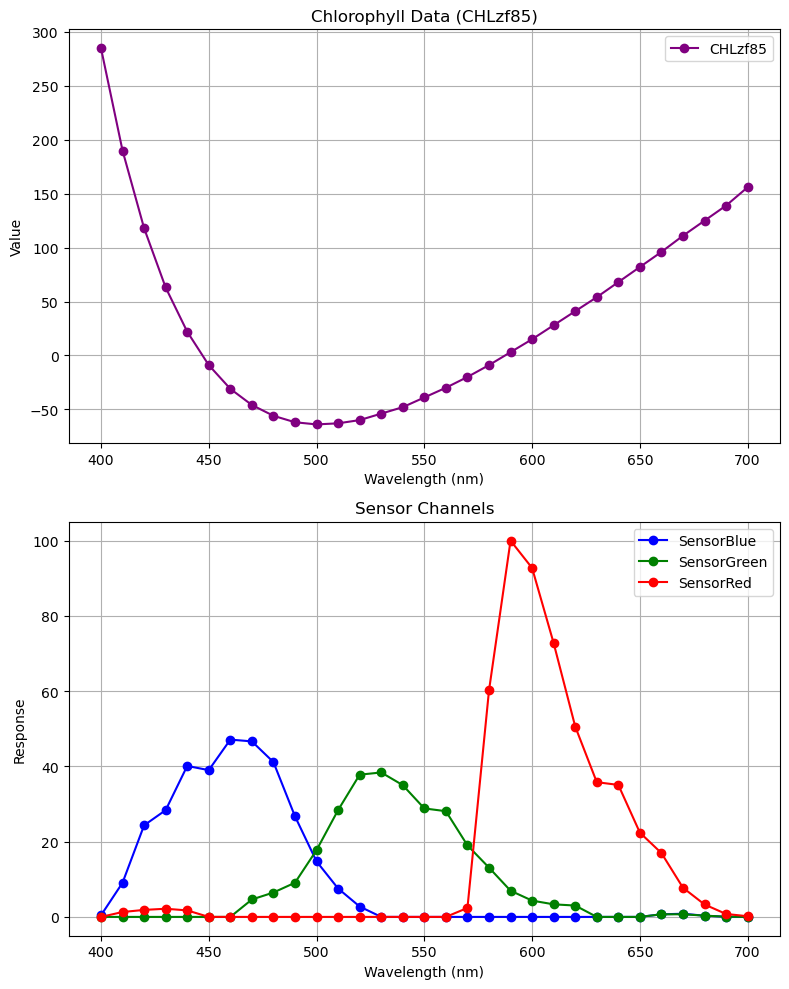

In [7]:
# Plotting the sensor data and CHL data

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot CHLzf85 (as points connected by lines)
ax[0].plot(CHLzf85[:,0], CHLzf85[:,1], marker='o', linestyle='-', color='purple', label='CHLzf85')
ax[0].set_title('Chlorophyll Data (CHLzf85)')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Value')
ax[0].legend()
ax[0].grid(True)

# Plot sensor channels: Blue, Green, and Red
ax[1].plot(SensorBlue[:,0], SensorBlue[:,1], marker='o', linestyle='-', color='blue', label='SensorBlue')
ax[1].plot(SensorGreen[:,0], SensorGreen[:,1], marker='o', linestyle='-', color='green', label='SensorGreen')
ax[1].plot(SensorRed[:,0], SensorRed[:,1], marker='o', linestyle='-', color='red', label='SensorRed')
ax[1].set_title('Sensor Channels')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Response')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


### b. Compute a Simplified Fringe Width
Use a threshold (e.g., 20% of the maximum absolute defocus value) to define the fringe region:

In [8]:
# Constant and parameters
K = 1.4 # A constant in threshold calculations.
xrange = 200 # Sets the range for the x-axis in plots.
defocusrange = 1000 # Defines the range of the defocus parameter (z).
tol = 0.15 # Tolerance value used to decide if there is a significant difference between color channels.

In [9]:
# Exposure function: uses a hyperbolic tangent to simulate sensor over-exposure effects.
def Exposure(x, F):
    return np.tanh(F * x) / np.tanh(F)

In [10]:
"""
edge_response()
A helper function to computes a weighted sum over the sensor’s spectral data. 

Parameters:
x: A position value (imagine it as distance from an edge).
z: A defocus value.
F: The over-exposure factor.
g: Gamma correction value.
sensor_data: The response values for one color channel.
"""

def edge_response(x, z, F, g, sensor_data):
    sum_response = 0.0
    denominator = math.sqrt(4 * (K**2) - 1)
    for n in range(len(CHLdata)):
        threshold = abs((z - CHLdata[n]) / denominator)
        if x >= threshold:
            weight = 1
        elif x <= -threshold:
            weight = 0
        else:
            weight = 0.5 * (1 + x / threshold)
        sum_response += sensor_data[n] * weight
    norm = np.sum(sensor_data)
    # Apply exposure and gamma correction
    val = Exposure(sum_response / norm, F)
    return val ** g

In [11]:
# Edge functions for each channel.
def EdgeR(x, z, F, g):
    return edge_response(x, z, F, g, SensorReddata)

def EdgeG(x, z, F, g):
    return edge_response(x, z, F, g, SensorGreendata)

def EdgeB(x, z, F, g):
    return edge_response(x, z, F, g, SensorBluedata)

In [12]:
"""
Computes the edge responses (er, eg, eb) for Red, Green, and Blue at the position x.
Checks if the difference between any two channels is greater than the tolerance (tol = 0.15).
Returns 1 if there is a significant difference (indicating a color fringe), otherwise returns 0.
"""

# Determines if there is a significant difference between the channels.
def Farbsaum(x, z, F, g):
    er = EdgeR(x, z, F, g)
    eg = EdgeG(x, z, F, g)
    eb = EdgeB(x, z, F, g)
    if abs(er - eb) > tol or abs(er - eg) > tol or abs(eg - eb) > tol:
        return 1
    else:
        return 0

In [13]:
# Sums the Farbsaum over the range of x.
def Farbsaumbreite(z, F, g):
    xs = np.arange(-xrange, xrange+1) # creates an array of x values from -200 to 200.
    return np.sum([Farbsaum(x, z, F, g) for x in xs]) # measuring how wide (in terms of number of x positions) the color fringe is.

In [14]:
# Combines the three channels into an RGB tuple.
def ColorFringe(x, z, F, g):
    return (EdgeR(x, z, F, g), EdgeG(x, z, F, g), EdgeB(x, z, F, g))

In [15]:
# Function to update the plots interactively.
def update_plot(z=0, F=1, g=1):
    xs = np.linspace(-xrange, xrange, 400)
    er_vals = [EdgeR(x, z, F, g) for x in xs]
    eg_vals = [EdgeG(x, z, F, g) for x in xs]
    eb_vals = [EdgeB(x, z, F, g) for x in xs]
    farb_vals = [Farbsaum(x, z, F, g) for x in xs]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the edge responses and Farbsaum indicator
    axs[0].plot(xs, er_vals, color='red', label='EdgeR')
    axs[0].plot(xs, eg_vals, color='green', label='EdgeG')
    axs[0].plot(xs, eb_vals, color='blue', label='EdgeB')
    axs[0].plot(xs, farb_vals, color='gray', label='Farbsaum')
    axs[0].set_title("Edge Responses & Farbsaum")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("Response")
    axs[0].legend()
    axs[0].set_ylim(0, 1)
    
    # Create a density plot using ColorFringe
    grid_y = np.linspace(0, 0.5 * xrange, 200) 
    X, Y = np.meshgrid(xs, grid_y)
    Z = np.zeros(X.shape + (3,)) 
    # Creates an empty array to store an RGB color (3 channels) for each grid point.
    
    # Compute the RGB value at each grid point (y is not used in computation, only x)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = ColorFringe(X[i, j], z, F, g) 
            # For every (i, j) point in the grid, it computes the RGB color using ColorFringe and stores it in Z.
            
    Z = np.clip(Z, 0, 1) # Ensures that all RGB values are between 0 and 1.
    
    axs[1].imshow(Z, extent=[-xrange, xrange, 0, 0.5*xrange], origin='lower', aspect='auto')
    axs[1].set_title("Color Fringe Density Plot")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    
    plt.tight_layout()
    plt.show()

In [16]:
# Create interactive widgets to control the parameters.
interact(update_plot, 
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description='defocus'),
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description='over exposure factor'),
         g=FloatSlider(min=0.5, max=4, step=0.1, value=1, description='Gamma'))

interactive(children=(FloatSlider(value=0.0, description='defocus', max=1000.0, min=-1000.0, step=1.0), FloatS…

<function __main__.update_plot(z=0, F=1, g=1)>

## 3. Photorealistic PSF Simulation

### a. Create a Synthetic Edge Image
Generate a sharp edge image that will be used for convolution:

In [17]:
# Create a simple binary edge image (step function).
edge_img = np.zeros((200, 400))
edge_img[:, 200:] = 1  # left half 0, right half 1

# Interactive function to update and display the simulation.
def update_psf_fringe(F=1, g=1):
    rgb_result = simulate_fringe_with_psf(edge_img, psf_data, F=F, g=g)
    plt.figure(figsize=(6, 3))
    plt.imshow(rgb_result, origin='lower', extent=[0, 400, 0, 200])
    plt.title("Color Fringe with Adjustable Overexposure Factor")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

### b. Simulate a Channel Image by Convolving with PSFs and Form the Image
Define a function that loops over wavelengths, uses the corresponding PSF, and weights the contribution by the sensor response:

In [35]:
# Function to simulate the color fringe using the PSF data.
def simulate_fringe_with_psf(edge_img, psf_data, F=1, g=1):
    """
    Simulate the color fringe on the focal plane using real PSF data.
    
    Parameters:
        edge_img: 2D numpy array
            The edge image (e.g., a binary step function) on the focal plane.
        psf_data: dict
            A dictionary mapping wavelengths (400, 410, ..., 700) to 2D PSF arrays.
        F: float
            Overexposure factor.
        g: float
            Gamma correction factor.
    
    Returns:
        rgb_image: 3D numpy array (height x width x 3)
            The simulated RGB image showing the color fringe.
    """
    wavelengths = np.arange(400, 701, 10)
    
    # Sensor responses for each channel.
    sensor_R = SensorReddata
    sensor_G = SensorGreendata
    sensor_B = SensorBluedata
    
    # Initialize accumulators for each channel.
    red_acc   = np.zeros_like(edge_img, dtype=float)
    green_acc = np.zeros_like(edge_img, dtype=float)
    blue_acc  = np.zeros_like(edge_img, dtype=float)
    
    # Total sensor response for normalization.
    norm_R = np.sum(sensor_R)
    norm_G = np.sum(sensor_G)
    norm_B = np.sum(sensor_B)
    
    # Process each wavelength.
    for i, wl in enumerate(wavelengths):
        if wl in psf_data:
            psf = psf_data[wl]
            conv_result = convolve2d(edge_img, psf, mode='same', boundary='symm')
            red_acc   += sensor_R[i] * conv_result
            green_acc += sensor_G[i] * conv_result
            blue_acc  += sensor_B[i] * conv_result
        else:
            print(f"Warning: PSF data for wavelength {wl} not found.")
    
    # Normalize responses.
    red_norm   = red_acc   / norm_R
    green_norm = green_acc / norm_G
    blue_norm  = blue_acc  / norm_B
    
    # Apply overexposure and gamma correction.
    red_exposed   = Exposure(red_norm, F)
    green_exposed = Exposure(green_norm, F)
    blue_exposed  = Exposure(blue_norm, F)
    
    red_gamma   = red_exposed ** g
    green_gamma = green_exposed ** g
    blue_gamma  = blue_exposed ** g
    
    # Combine channels into an RGB image.
    rgb_image = np.stack((red_gamma, green_gamma, blue_gamma), axis=-1)
    return np.clip(rgb_image, 0, 1) 

In [36]:
# Create sliders for F (overexposure factor) and g (gamma correction).
interact(update_psf_fringe, 
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description='Overexposure F'),
         g=FloatSlider(min=0.5, max=4, step=0.1, value=1, description='Gamma'))

interactive(children=(FloatSlider(value=1.0, description='Overexposure F', max=16.0, min=1.0), FloatSlider(val…

<function __main__.update_psf_fringe(F=1, g=1)>

## 5. Parameter Tuning and Optimization

### a. Loop Over Parameters to Assess Effects
For example, vary the overexposure factor and compute a simple metric (e.g., average fringe contrast) to find the best parameter.